# Robertson System: ODE vs Index-1 DAE Formulation

This notebook compares the classic stiff Robertson ODE system with its reformulation as a semi-explicit index-1 DAE using a singular mass matrix. Both are solved using SciPy’s `solve_ivp` interface.

---

## 📘 Background

The Robertson system models a stiff chemical reaction network: **ODE System**
$$
\begin{aligned}
\frac{dy_0}{dt} &= -0.04\,y_0 + 10^4\,y_1\,y_2 \\
\frac{dy_1}{dt} &= 0.04\,y_0 - 10^4\,y_1\,y_2 - 3 \times 10^7\,y_1^2 \\
\frac{dy_2}{dt} &= 3 \times 10^7\,y_1^2
\end{aligned}
$$

Initial condition:
$$
y(0) = [1,\;0,\;0]
$$

Invariant: **DAE system**

$$
y_0 + y_1 + y_2 = 1
$$

This allows reformulating the system as a semi-explicit index‑1 DAE:

$$
\begin{align*}
\frac{dy_0}{dt} &= -0.04\,y_0 + 10^4\,y_1\,y_2 \\
\frac{dy_1}{dt} &= 0.04\,y_0 - 10^4\,y_1\,y_2 - 3 \times 10^7\,y_1^2 \\
0 &= y_0 + y_1 + y_2 - 1
\end{align*}
$$


- Treat $y_2$ as algebraic.
- Introduce a singular mass matrix:
  $$
  M = \begin{bmatrix}
  1 & 0 & 0 \\
  0 & 1 & 0 \\
  0 & 0 & 0
  \end{bmatrix}
  $$

**Reference**:
- Robertson, H.H. (1966). *The solution of a set of reaction rate equations*. In Numerical Analysis: An Introduction. Academic Press.

---

## 📦 Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time as pytime

# Custom solve_ivp solver
from radauDAE import RadauDAE

## 🧮 Define ODE and DAE models


In [2]:
def modelfun_ODE(t, y):
    """Classic stiff ODE version of the Robertson system."""
    y1, y2, y3 = y
    return np.array([
        -0.04 * y1 + 1e4 * y2 * y3,
         0.04 * y1 - 1e4 * y2 * y3 - 3e7 * y2**2,
         3e7 * y2**2
    ])

In [3]:
def modelfun_DAE(t, y):
    """Index-1 DAE version with algebraic constraint y0 + y1 + y2 = 1."""
    y1, y2, y3 = y
    return np.array([
        -0.04 * y1 + 1e4 * y2 * y3,
         0.04 * y1 - 1e4 * y2 * y3 - 3e7 * y2**2,
         y1 + y2 + y3 - 1
    ])

In [4]:
def jac_dae(t, y):
    """Jacobian of the DAE system.
    Analytical Jacobian for the DAE formulation.
    
    J = ∂f/∂y = [[∂f0/∂y0, ∂f0/∂y1, ∂f0/∂y2],
                 [∂f1/∂y0, ∂f1/∂y1, ∂f1/∂y2], 
                 [∂f2/∂y0, ∂f2/∂y1, ∂f2/∂y2]]
   """
    
    y1, y2, y3 = y
    return np.array([
        [0.04,   -1e4 * y3,          -1e4 * y2],
        [-0.04,  1e4 * y3 + 6e7 * y2, 1e4 * y2],
        [1.0,    1.0,                 1.0]
    ])

## ⚙️ Integration setup

In [5]:
# time span
t0 = 0
tf = 4e10
t_span = (t0, tf)
t_eval = None

# initial conditions
y0 = np.array([1, 0, 0], dtype=float)
  
rtol=1e-7; atol=rtol/10 #1e-6 # absolute and relative tolerances for time step adaptation


## 🚀 Solve ODE with Radau from Scipy

In [6]:
# solve the ODE formulation
t1 = pytime.time()
sol_ode = solve_ivp(fun=modelfun_ODE, t_span=t_span, y0=y0,
                    rtol=rtol, atol=atol,
                    method='BDF',
                    dense_output=True)
t2 = pytime.time()
sol_ode.CPUtime = t2-t1

## 🚀 Solve DAE with RadauDAE


### RadauDAE solver setup

In [7]:
# Mass matrix
mass     = np.array([[1.,0.,0.],
                     [0.,1.,0.],
                     [0.,0.,0.]])
# Variable index: 0 = differential, 1 = algebraic
var_index = np.array([0,0,1]) 

# The new method for solving DAEs and implicit ODEs
method = RadauDAE

### Call RadauDAE solver

In [8]:
# solve the DAE formulation
t1 = pytime.time()
# Solve the Differential-Algebraic Equation system using RadauDAE method
sol_dae = solve_ivp(fun=modelfun_DAE,     # DAE system function
                t_span=(0., tf),      # Time integration range [start, end]
                y0=y0,                # Initial condition vector
                method=method,         # Using RadauDAE solver for stiff DAEs
                mass_matrix=mass,     # Mass matrix defining DAE structure
                rtol=rtol,            # Relative tolerance for error control
                atol=atol,            # Absolute tolerance for error control               
                dense_output=True,     # Enable solution interpolation between points
                var_index=var_index,   # Variable type classification array                
                # max_step=np.inf,       # No upper limit on time step size
                # vectorized=False,      # Function is not vectorized (single evaluation)
                # first_step=1e-8,       # Initial time step size [s] (very small for startup)

              
                # # RadauDAE-specific parameters for Newton iterations:
                # max_newton_ite=150,    # Maximum Newton iterations per time step
                # max_bad_ite=20,        # Maximum failed step attempts before reducing step size
                # min_factor=0.2,        # Minimum step size reduction factor (80% reduction max)
                # max_factor=10,         # Maximum step size increase factor (10x increase max)
                # newton_tol=1e-3,       # Tolerance for Newton iteration convergence
                
                # # Numerical scaling options for better conditioning:
                # scale_residuals = True,   # Scale residuals to improve numerical stability
                # scale_newton_norm = True, # Scale Newton update norms for better convergence
                # scale_error = True,       # Scale error estimates for adaptive step control
                
                )      

t2 = pytime.time()    
sol_dae.CPUtime = t2-t1

## 📊 Solver statistics

In [9]:
for sol, name in ((sol_dae, 'DAE'), (sol_ode, 'ODE')):
    # Modern SciPy OdeResult already exposes status and message
    state = 'solved' if sol.success else 'failed'
    print(f"\n{name} {state}")
    print(f"\t{sol.t.size-1} time steps in {sol.CPUtime:.3f}s")
    print(f"\tstatus={sol.status}, message={sol.message}")
    print(f"\t{sol.nfev} fev, {sol.njev} jev, {sol.nlu} LU dec")


DAE solved
	360 time steps in 0.369s
	status=0, message=The solver successfully reached the end of the integration interval.
	3188 fev, 124 jev, 217 LU dec

ODE solved
	576 time steps in 0.296s
	status=0, message=The solver successfully reached the end of the integration interval.
	1733 fev, 22 jev, 127 LU dec


## 📈 Visual comparison of ODE vs DAE solutions


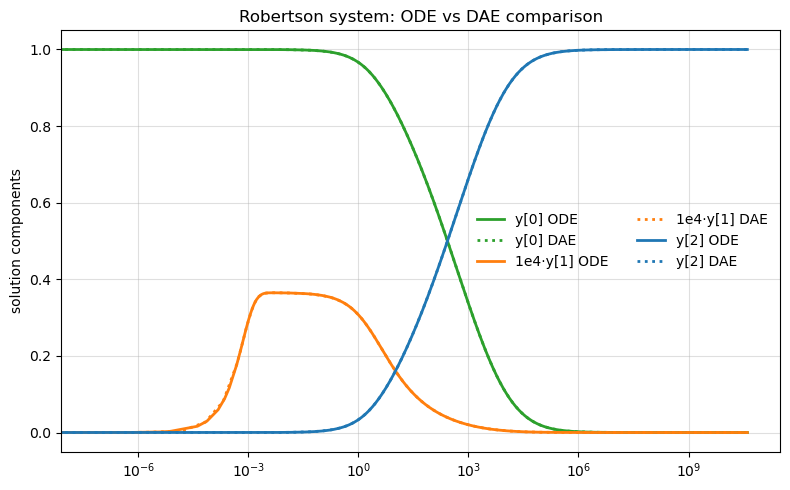

In [10]:
colors = {"y0": "tab:green", "y1": "tab:orange", "y2": "tab:blue"}

plt.figure(figsize=(8,5))
plt.semilogx(sol_ode.t, sol_ode.y[0], color=colors["y0"], lw=2, ls="-", label="y[0] ODE")
plt.semilogx(sol_dae.t, sol_dae.y[0], color=colors["y0"], lw=2, ls=":", label="y[0] DAE")

plt.semilogx(sol_ode.t, 1e4 * sol_ode.y[1], color=colors["y1"], lw=2, ls="-", label="1e4·y[1] ODE")
plt.semilogx(sol_dae.t, 1e4 * sol_dae.y[1], color=colors["y1"], lw=2, ls=":", label="1e4·y[1] DAE")

plt.semilogx(sol_ode.t, sol_ode.y[2], color=colors["y2"], lw=2, ls="-", label="y[2] ODE")
plt.semilogx(sol_dae.t, sol_dae.y[2], color=colors["y2"], lw=2, ls=":", label="y[2] DAE")

plt.ylabel("solution components")
plt.legend(ncol=2, frameon=False)
plt.grid(True, alpha=0.4)
plt.title("Robertson system: ODE vs DAE comparison")
plt.tight_layout()
plt.show()


## 🧠 Pedagogical Notes

- The Robertson system is a benchmark for stiff ODE solvers due to its wide range of time scales.
- Reformulating it as a DAE using the invariant $y_0 + y_1 + y_2 = 1$ introduces an algebraic constraint.
- The singular mass matrix allows implicit solvers to enforce this constraint while integrating the dynamics.
- RadauDAE handles the DAE robustly using Newton iterations and LU factorizations.
- Comparing both formulations validates the correctness of the DAE approach and highlights solver behavior.

---

## 📚 References

- Robertson, H.H. (1966). *The solution of a set of reaction rate equations*. In Numerical Analysis: An Introduction. Academic Press.
- Hairer, E., & Wanner, G. (1996). *Solving Ordinary Differential Equations II: Stiff and Differential-Algebraic Problems*. Springer.